In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd

import json

from glob import glob
import os

from importlib import reload

import utils
import persim
import itertools

from sklearn import manifold, cluster, preprocessing
import tifffile as tf
from KDEpy import FFTKDE
from scipy import ndimage,stats,spatial

In [2]:
nuclei_mask_cutoff = 1
seed = 42
ndims = 3
fs = 12
PP = 6
dpi = 96
minlife = 0.0
rng = np.random.default_rng(seed)
pos = rng.normal(1, 0.25, 10000)
Cmap='plasma'
pxs = 75
pxbar = np.s_[-25:-5, 5:5 + pxs]
s = 50
alphaNmin = 0.1
alphaNmax = 10

marker = ['D', '8', 's', '^', 'v', 'P', 'X', '*']
color = ['#56b4e9', '#f0e442', '#009e73', '#0072b2', '#d55e00', '#cc79a7', '#e69f00', '#e0e0e0', '#000000']
cmap = ['Blues_r', 'Wistia', 'Greens_r', 'BuPu_r', 'Oranges_r', 'RdPu_r', 'YlOrBr_r', 'gray', 'gist_gray']
box_params = {'widths':0.75, 'patch_artist':True, 'medianprops':{'lw':3, 'color':'red'} }
#figdst = os.path.expanduser('~') + '/documents/website/mcarto/figs/'
sample = 'D2'

wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
tsrc = '../translocs/'
ksrc = '../kde/'
isrc = '..' + os.sep + 'infected_focus_summer24' + os.sep 

isrc += sample + os.sep
ksrc += sample + os.sep

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col='ndimage_cellID')
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv').set_index('gene')
weight = np.load(ksrc + sample + '_border_weights.npy', allow_pickle=True)
transcriptomes = np.asarray(list(metatrans['gene']))
metatrans = metatrans.set_index('gene')

Cells = utils.get_range_cell_values(isrc + 'infected_cells_ids.csv', metacell, startval=1)
Cells = np.setdiff1d( Cells, metacell[metacell['number_nuclei'] > 1].index)

Genes = utils.get_range_gene_values(isrc + 'genes_to_focus_infection.csv', transcriptomes, startval=0)
invGenes = dict(zip(Genes, range(len(Genes))))
invCells = dict(zip(Cells, range(len(Cells))))
transfocus = transcell.loc[transcriptomes[Genes], Cells.astype(str)]

wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
label, cellnum = ndimage.label(wall, ndimage.generate_binary_structure(2,1))
css = ndimage.find_objects(label)
wall[tf.imread(nsrc + sample + '_EDT.tif') < nuclei_mask_cutoff] = False
wcoords = np.asarray(np.nonzero(~wall))
wallshape = wall.shape
wc = wcoords[:, ~np.all(wcoords%100, axis=0)]

translocs = [None for i in range(len(transcriptomes))]
for i in range(len(transcriptomes)):
    filename = tsrc + sample + os.sep + 'location_corrected_D2_-_' + transcriptomes[i] + '.csv'
    translocs[i] = pd.read_csv(filename, header=None, names=['X', 'Y', 'Z'])
tlocs = pd.concat(translocs)
tcumsum = np.hstack(([0], np.cumsum(metatrans['cyto_number'].values)))

handles = [None for _ in range(len(Genes))]
for i in range(len(handles)):
    handles[i] = mlines.Line2D([], [], mfc=color[i], marker=marker[i], ls='None', mec='k', mew=1, ms=7)

transfocus

169   188  199  209   224  227  233   235   236  243  ...  \
gene                                                                   ...   
GLYMA_17G195900  966  2402  727  307  1012  901  828  1263  1314  315  ...   
GLYMA_05G216000   27    29   20    2    12   21    8    19    23    0  ...   
GLYMA_17G185800   22    48   10   12     5    5   24    21    27   15  ...   
GLYMA_05G203100    3    21    0    0     0    0    0     3     2    1  ...   
GLYMA_15G210100   11    35   14   14    10    5   28    24    20    7  ...   
GLYMA_05G092200  462  1685  638  502   462  481  629   978   694  320  ...   

                 2511  2514  2515  2523  2529  2536  2548  2552  2573  2576  
gene                                                                         
GLYMA_17G195900   810  1268   181   210  1106   363   679   760   574   772  
GLYMA_05G216000     9     8     2     3    19     4    10     7     8    22  
GLYMA_17G185800    16    10     1     3     3    13    10    13     7     2  
GLYMA_05G203100     1     0     1     0    13     0     1     0     0     0  
GLYMA_15G210100    15    18     3     5    16     8    16     6    12     6  
GLYMA_05G092200   655   818   196   407  1067   417   428   714   344   478  

[6 rows x 926 columns]

In [3]:
level = 'sub'
normtype = 'both'
bw = 20
stepsize = 3
SCALE = 16

zmax = np.max(tlocs['Z']+stepsize)
zbins = np.arange(0, zmax+stepsize, stepsize)

dsrc = isrc + 'G{}_{}level_{}_step{}_bw{}'.format(len(Genes), level, normtype, stepsize, bw) + os.sep
ratios = utils.normalize_counts(transfocus, normtype)

jsonfiles = [ [ None for j in range(ratios.shape[1]) ] for i in range(ratios.shape[0]) ]
gsrc = '../{}level/'.format(level) + sample + os.sep
for i in range(len(jsonfiles)):
    foo = '{}{}/{}_-_{}_p{}_s{}_bw{}_c{:06d}.json'
    for j in range(len(jsonfiles[0])):
        filename = foo.format(gsrc, transcriptomes[Genes[i]],transcriptomes[Genes[i]],level,PP,stepsize,bw,Cells[j])
        if os.path.isfile(filename):
            jsonfiles[i][j] = filename

In [4]:
orig_diags = [ utils.get_diagrams(jsonfiles[i], ndims, remove_inf=True) for i in range(len(jsonfiles))]
orig_diags, rescale, maxlife, focus_dim = utils.normalize_persistence_diagrams(orig_diags, ratios, normtype, SCALE)

kde_max = np.zeros(ratios.size)
for i in range(len(orig_diags)):
    for j in range(len(orig_diags[i])):
        if len(orig_diags[i][j][focus_dim]) > 0:
            kde_max[i*len(orig_diags[i]) + j] = np.max(orig_diags[i][j][focus_dim])

kmax = np.sort(kde_max)[-20]

lt_mask = np.any(maxlife > minlife, axis=2)
gmask, cmask = np.nonzero(lt_mask)

bsummary = pd.DataFrame()
bsummary['gene_ID'] = Genes[gmask]
bsummary['ndimage_ID'] = Cells[cmask]
uq , cts = np.unique(gmask, return_counts=True)
nzcumsum = np.hstack(([0], np.cumsum(cts) ))

if normtype == 'gene':
    diags = [ [ [ rescale[i][0][0]*orig_diags[i][j][k].copy() for k in range(len(orig_diags[i][j])) ] for j in range(len(orig_diags[i])) ] for i in range(len(orig_diags)) ]
elif normtype == 'both':
    diags = [ [ [ rescale*orig_diags[i][j][k].copy() for k in range(len(orig_diags[i][j])) ] for j in range(len(orig_diags[i])) ] for i in range(len(orig_diags)) ]
for i in range(len(diags)):
    for j in range(len(diags[i])):
        for k in range(len(diags[i][j])):
            diags[i][j][k] = np.atleast_2d(diags[i][j][k][ diags[i][j][k][:,1] - diags[i][j][k][:,0] > minlife, : ])

full_lt_coll = [ [None for _ in range(np.sum(lt_mask)) ] for _ in range(ndims) ]
for i in range(len(gmask)):
    for k in range(len(full_lt_coll)):
        d = diags[gmask[i]][cmask[i]][k]
        full_lt_coll[k][i] = np.column_stack( (d[:, 0], d[:, 1] - d[:, 0])  )

maxbirth = 0
for k in range(len(full_lt_coll)):
    for i in range(len(full_lt_coll[k])):
        if len(full_lt_coll[k][i]) > 0:
            b = np.max(full_lt_coll[k][i][:,0])
            if b > maxbirth:
                maxbirth = b

maxbirth

Initial number of life-birth pairs	: 166394

No. of diagrams s.t. H_k had the most persistent component
H_0:	747 [ 13.4% ]
H_1:	3 [ 0.1% ]
H_2:	4806 [ 86.5% ]

Will focus just on dimension k = 2



13.56012686924986

# Bring in persistence images to the party

In [5]:
sigma = 1
pers_w = 1
pixel_size = 1

pi_params = {'birth_range':(0,min([SCALE, int(np.ceil(maxbirth + sigma))] )),
             'pers_range':(0,min([SCALE, int(np.ceil(maxlife[:,:,focus_dim].max()+sigma))])),
             'pixel_size': pixel_size,
             'weight': 'persistence',
             'weight_params': {'n': pers_w},
             'kernel':'gaussian',
             'kernel_params':{'sigma': [[sigma, 0.0], [0.0, sigma]]} }
                       
pimgr = persim.PersistenceImager(**pi_params)
extent = np.array([ pimgr.birth_range[0], pimgr.birth_range[1], pimgr.pers_range[0], pimgr.pers_range[1] ]).astype(int)
full_img = np.zeros((len(full_lt_coll), len(full_lt_coll[0]), extent[1], extent[3]))
for k in range(len(full_img)):
    full_img[k] = np.asarray(pimgr.transform(full_lt_coll[k], skew=False))
full_img[full_img < 0] = 0

# Pipeline figure

In [6]:
method = 'PCA'
hdims = np.array([1,2])
Pname = ' [$' + ' \\oplus '.join(['H_{}'.format(k) for k in hdims]) + '$]'
pname = 'H' + '+'.join(hdims.astype(str))
csvfilename = dsrc + 'scale{}_-_PI_{}_{}_{}_pca_{}.csv'.format(SCALE, sigma, pers_w, pixel_size, pname )
print(csvfilename)
embedding = pd.read_csv(csvfilename)
pca = embedding.iloc[:,2:4].values
foo = [bw, stepsize, level.title(), normtype.title(), sigma, pers_w]
Bname = 'KDE bandwidth {}, stepsize {}. {}level persistence. {} normalized. PIs $\sigma = {}$. Weighted by $n^{{{}}}$.'.format(*foo)
bname = 'scale{}_-_PI_{}_{}_{}_'.format(SCALE, sigma, pers_w, pixel_size)

../infected_focus_summer24/D2/G6_sublevel_both_step3_bw20/scale16_-_PI_1_1_1_pca_H1+2.csv


In [43]:
steps = 1
llim = int(np.floor(pca[:,0].min()))
rlim = int(np.ceil(pca[:,0].max()))

blim = int(np.floor(pca[:,1].min()))
tlim = int(np.ceil(pca[:,1].max()))
print(llim, tlim, rlim, blim)

yaxis = np.linspace(blim, tlim, int(steps*(tlim - blim))+1)[::-1]
xaxis = np.linspace(llim, rlim, int(steps*(rlim - llim))+1)
AXES = np.meshgrid(yaxis, xaxis, indexing='ij')
grid = np.column_stack([ np.ravel(AXES[i]) for i in range(len(AXES)) ])

dists = spatial.distance.cdist(np.flip(grid, axis=1), pca, metric='euclidean')
mindist = np.min(dists, axis=1)
minmask = mindist < 1/(4*steps)

blim, llim = np.min(grid[minmask], axis=0)
tlim, rlim = np.max(grid[minmask], axis=0)
print(llim, tlim, rlim, blim)

yaxis = np.linspace(blim, tlim, int(steps*(tlim - blim))+1)[::-1]
xaxis = np.linspace(llim, rlim, int(steps*(rlim - llim))+1)
AXES = np.meshgrid(yaxis, xaxis, indexing='ij')
grid = np.column_stack([ np.ravel(AXES[i]) for i in range(len(AXES)) ])

dists = spatial.distance.cdist(np.flip(grid, axis=1), pca, metric='euclidean')
argmin = np.argmin(dists, axis=1)
mindist = np.min(dists, axis=1)
minmask = mindist < 1/(4*steps)
reps = argmin[minmask]
print(reps.shape)

-2 3 6 -3
-1.0 3.0 5.0 -2.0
(24,)


In [44]:
lt_coll = [None for _ in range(len(reps))]
for i in range(len(lt_coll)):
    foo = [full_lt_coll[k][reps[i]].copy() for k in hdims]
    for j in range(1, len(hdims)):
        foo[j][:,0] += j*full_img.shape[2]
    lt_coll[i] = np.vstack(foo)
    
img = np.hstack(full_img[hdims])[reps]
vmax = np.quantile(img[img > 0], 0.99)
nrow = int((tlim - blim)*steps)+1
ncol = int((rlim - llim)*steps)+1

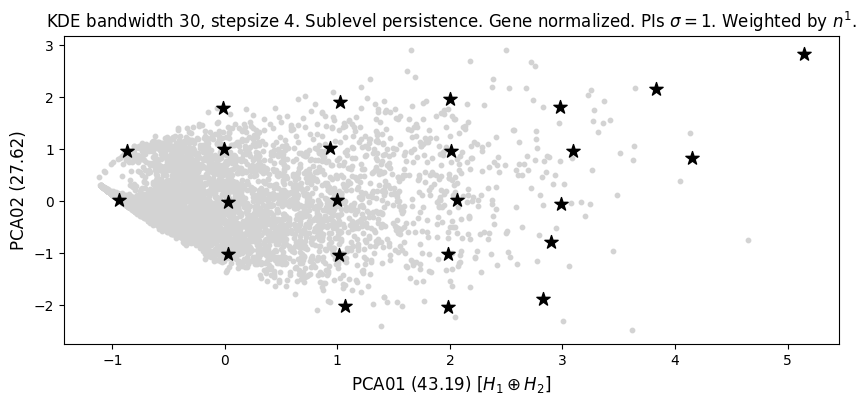

In [45]:
fig, ax = plt.subplots( 1,1, figsize=(10, 4), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].set_title(Bname, fontsize=fs)
ax[i].scatter(pca[:,0], pca[:,1], c='lightgray', marker='o', s=10, alpha=1, zorder=1)
ax[i].scatter(pca[reps,0], pca[reps,1], c='k', marker='*', s=100, alpha=1, zorder=2)
ax[i].set_xlabel(embedding.columns[2]+Pname, fontsize=fs)
ax[i].set_ylabel(embedding.columns[3], fontsize=fs)
filename = dsrc + bname + method.lower() + '_' + pname + '_gridded'
#plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

../infected_focus_summer24/D2/G6_sublevel_gene_step4_bw30/scale16_-_PI_1_1_1_pca_H1+2_PI_sample


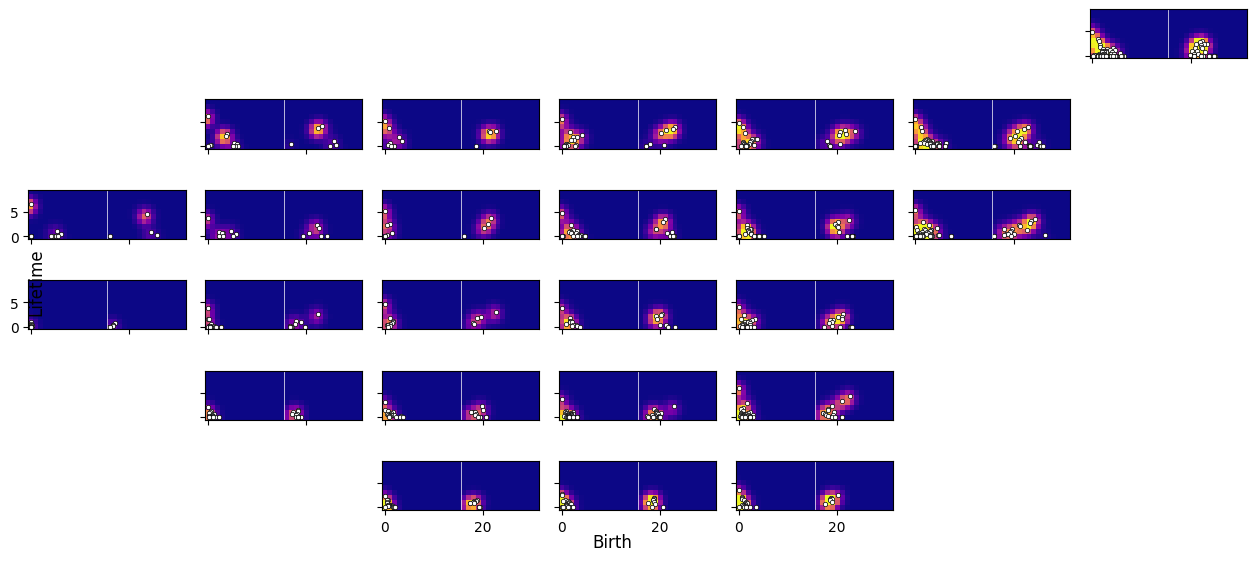

In [47]:
fig, ax = plt.subplots( nrow, ncol, figsize=(13, (0+0.5*len(hdims))*nrow), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel();

for i, j in enumerate(np.nonzero(minmask)[0]):
    ax[j].imshow(img[i].T, cmap=Cmap, vmin=0, vmax=vmax, origin='lower')
    for k in range(1, len(hdims)):
        ax[j].axvline(k*full_img.shape[2] - .5, c='white', lw=0.5)
    ax[j].scatter(lt_coll[i][:,0], lt_coll[i][:,1], c='w', marker='o', s=10, edgecolor='k', linewidth=0.5)

foo = np.nonzero(~minmask)[0]
if len(foo) > 0:
    for j in foo:
        fig.delaxes(ax[j])

fig.supxlabel('Birth', fontsize=fs, y=0.05)
fig.supylabel('Lifetime', fontsize=fs, x=0.05)
fig.tight_layout();
filename = dsrc + bname + method.lower() + '_' + pname + '_PI_sample'
print(filename)
#plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

In [48]:
KDE = [None for _ in range(len(reps))]
hcells = [None for _ in range(len(reps))]
hcoords = [None for _ in range(len(reps))]
hextent = [None for _ in range(len(reps))]
hzhist = [None for _ in range(len(reps))]

for i in range(len(KDE)):
    cidx = embedding.loc[reps[i], 'ndimage_ID']
    cell, cextent = utils.get_cell_img(cidx, metacell, wall, label, pxbar=False)
    axes, grid, kdegmask, cgrid, cgridmask = utils.cell_grid_preparation(cell, cextent, zmax, stepsize)
    cmask = label[ translocs[ embedding.loc[reps[i], 'gene_ID']]['Y'], translocs[embedding.loc[reps[i], 'gene_ID']]['X'] ] == cidx
    coords = translocs[embedding.loc[reps[i], 'gene_ID']].iloc[cmask].values.T
    zhist, _ = np.histogram(coords[2], bins=zbins, density=True)
    
    w = weight[tcumsum[embedding.loc[reps[i], 'gene_ID']] : tcumsum[embedding.loc[reps[i], 'gene_ID']+1]][cmask]
    kde = FFTKDE(kernel='gaussian', bw=bw, norm=2).fit(coords.T, w).evaluate(grid)
    kde = kde[kdegmask]/( np.sum(kde[kdegmask]) * (stepsize**len(coords)) )
    kde[ cgridmask ] = 0
    kde = kde/( np.sum(kde) * (stepsize**len(coords)) )
    
    KDE[i] = kde.reshape( list(map(len, axes))[::-1], order='F')
    hcells[i] = cell
    hextent[i] = cextent
    hcoords[i] = coords
    hzhist[i] = zhist

for cell in hcells:
    cell[pxbar] = 0

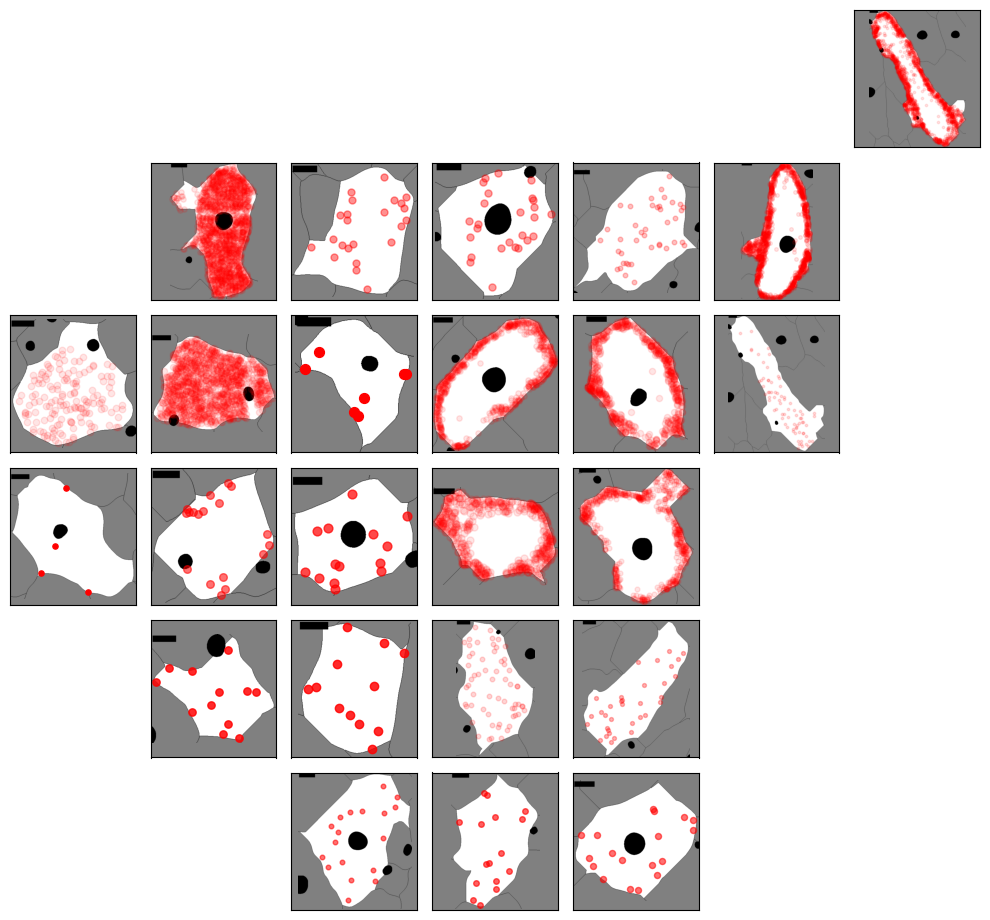

In [52]:
fig, ax = plt.subplots( nrow, ncol, figsize=(10, 1.55*nrow), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel();

for i, j in enumerate(np.nonzero(minmask)[0]):
    ax[j].imshow(hcells[i], cmap='binary_r', origin='lower', extent=hextent[i], vmin=0, vmax=2);
    ax[j].scatter(*hcoords[i][:2], color='r', marker='o', 
                  alpha=max([ alphaNmin, min([1, alphaNmax/len(hcoords[i][0])])]), s=int(4e6/hcells[i].size))
    ax[j].set_facecolor('#808080')
    ax[j].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

foo = np.nonzero(~minmask)[0]
if len(foo) > 0:
    for j in foo:
        fig.delaxes(ax[j])

for a in ax.ravel():
    a.set_aspect('equal','datalim')
    
fig.tight_layout();
filename = dsrc + bname + method.lower() + '_' + pname + '_cell_sample'
#plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

In [113]:
hkdes = [ KDE[i].copy() * ratios[invGenes[embedding.loc[reps[i], 'gene_ID']]][ invCells[embedding.loc[reps[i], 'ndimage_ID']] ] for i in range(len(KDE))]
if normtype == 'gene':
    for i in range(len(hkdes)):
        hkdes[i] *= rescale[invGenes[embedding.loc[reps[i], 'gene_ID']]][0][0]
#kx = np.quantile( np.hstack([ hkdes[i][hkdes[i] > 1e-20] for i in range(len(hkdes)) ]), 0.999)
#kx = np.max(list(map(np.max, hkdes)))
hzlevel = np.array(list(map(np.argmax, hzhist)))

In [421]:
dsrc + bname + method.lower() + '_' + pname + '_kde_sample'

'../infected_focus_summer24/D2/G6_sublevel_both_step3_bw25/scale16_-_PI_1_1_1_pca_H1+2_kde_sample'

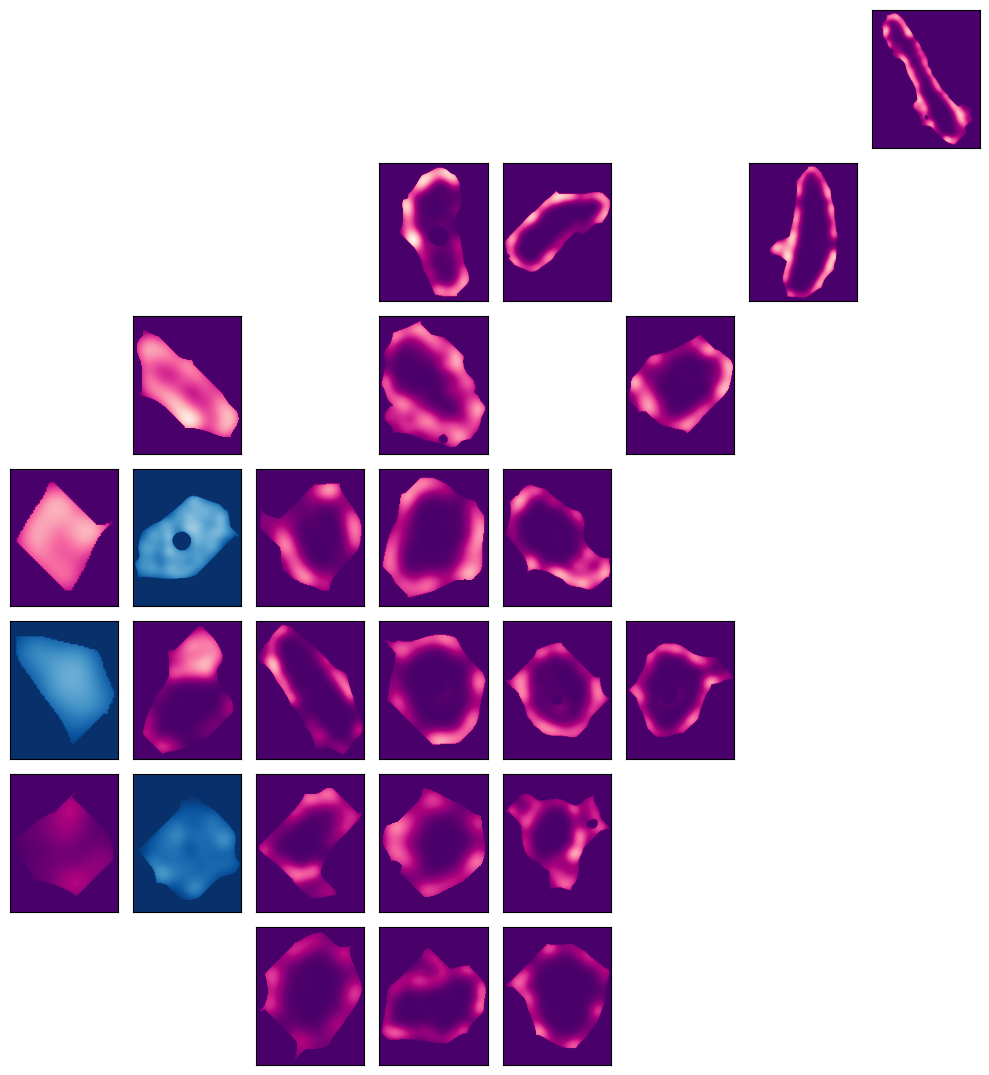

In [170]:
fig, ax = plt.subplots( nrow, ncol, figsize=(10, 1.55*nrow), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel();

for i, j in enumerate(np.nonzero(minmask)[0]):
    ax[j].imshow(hkdes[i][hzlevel[i],:,:], origin='lower', cmap=cmap[gmask[reps[i]]], vmin=0, vmax=kmax, zorder=1)
    ax[j].set_facecolor( mpl.colormaps[cmap[gmask[reps[i]]]](0) )
    ax[j].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

foo = np.nonzero(~minmask)[0]
if len(foo) > 0:
    for j in foo:
        fig.delaxes(ax[j])

for a in ax.ravel():
    a.set_aspect('equal','datalim')
    
fig.tight_layout();
filename = dsrc + bname + method.lower() + '_' + pname + '_kde_sample'
#plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

# Explore a PCA continuum

In [10]:
gidx = 5
ord = 1
Cmap = 'plasma'

pmask = embedding['gene_ID'] == Genes[gidx]

cellloc = metacell.loc[ embedding.loc[pmask, 'ndimage_ID'], ['ndimage_comX','ndimage_comY','orig_cellID'] ].values

dists = spatial.distance.squareform(spatial.distance.pdist(cellloc[:,:2], metric='euclidean'), checks=False)
ecc = np.linalg.norm(dists, ord=ord, axis=1)
if ord < np.inf:
    ecc *= np.power(1/len(ecc), 1/ord)
ecc -= ecc.min()

../infected_focus_summer24/D2/G6_sublevel_both_step3_bw20/scale16_-_PI_1_1_1_pca_H1+2_GLYMA_05G092200


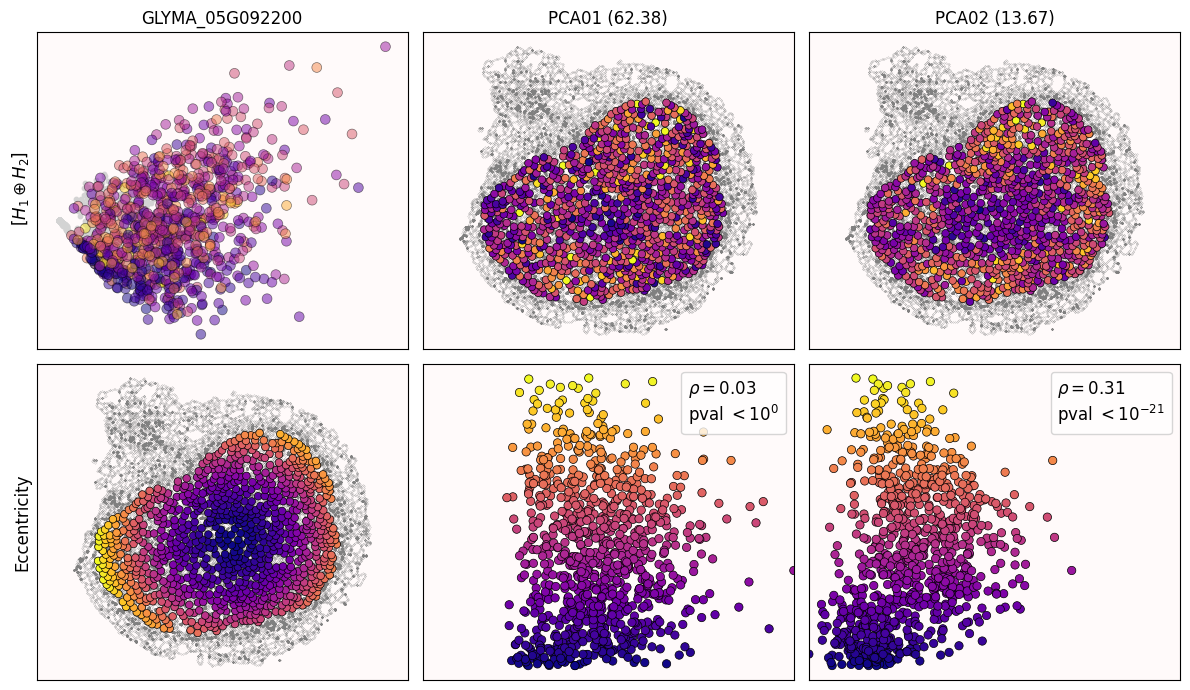

In [13]:
fig, ax = plt.subplots(2, 1+pca.shape[1], figsize=(12,7), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].scatter(pca[~pmask,0], pca[~pmask,1], c='lightgray', marker='o', s=10, zorder=1)
ax[i].scatter(*(pca[pmask].T), c=ecc, marker='o', s=50, zorder=2, cmap=Cmap, edgecolor='k', linewidth=0.5, alpha=0.5)
ax[i].set_ylabel(Pname, fontsize=fs)

for i,c in zip( range(1, 2+pca.shape[1]) , np.vstack((pca[pmask,:].T,ecc)) ):
    vmax = utils.maximum_qq_size(c, alpha=0.25, iqr_factor=1.5)
    vmin = utils.minimum_qq_size(c, alpha=0.25, iqr_factor=1.5)

    ax[i].scatter(wc[1], wc[0], c='#808080', marker='.', s=0.1, zorder=1)
    ax[i].scatter(*cellloc.T[:2], c=c, marker='o', cmap=Cmap,
                  edgecolor='black', linewidth=0.5, zorder=2, s=30, vmax=vmax, vmin=vmin)

ax[1+pca.shape[1]].set_ylabel('Eccentricity', fontsize=fs)
k = 2+pca.shape[1]
for i in range(pca.shape[1]):
    corr = stats.spearmanr(ecc, pca[pmask, i])
    expo = int(np.ceil(np.log10(corr.pvalue)))
    ll = '$\\rho = ${:.2f}\npval $< 10^{{{}}}$'.format(corr.statistic, expo)
    ax[i+k].scatter(pca[pmask,i], ecc, c=ecc, cmap=Cmap, marker='o', edgecolor='black', linewidth=0.5, label=ll)
    ax[i+k].set_xlim(pca[pmask].min(), pca[pmask].max())
    ax[i+k].legend(fontsize=fs, handlelength=0, handletextpad=0, loc='upper right', markerscale=0)

for i in range(2+pca.shape[1]):
    ax[i].set_aspect('equal','datalim')
title = [transcriptomes[Genes[gidx]]] + list(embedding.columns[2:2+pca.shape[1]]) + ['' for _ in range(len(ax))]
for i in range(len(ax)):
    ax[i].set_title(title[i], fontsize=fs)
    ax[i].set_facecolor('snow')
    ax[i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

fig.tight_layout();
filename = dsrc + bname + method.lower() + '_' + pname + '_{}'.format(transcriptomes[Genes[gidx]])
print(filename)
#plt.savefig(filename, dpi=dpi, bbox_inches='tight', pil_kwargs={'optimize':True})

In [14]:
pcnum = 0
arr = pca[pmask, pcnum]
vmax = utils.maximum_qq_size(arr, alpha=0.25, iqr_factor=1.5)
vmin = utils.minimum_qq_size(arr, alpha=0.25, iqr_factor=1.5)

qq = 0.1
hqmask = arr > np.quantile(arr, 1-qq)
lqmask = arr < np.quantile(arr, qq)
print(np.sum(hqmask), np.sum(lqmask))

93 93


In [16]:
N = 6
lq = rng.choice(np.nonzero(lqmask)[0], N, replace=False)
hq = rng.choice(np.nonzero(hqmask)[0], N, replace=False)
orig_idx = cellloc[np.hstack((lq,hq)), 2].astype(int)
cyto_area = metacell.loc[embedding.loc[pmask].iloc[np.hstack((lq,hq))]['ndimage_ID'], 'cyto_area']
tnum = transcell.loc[transcriptomes[Genes[gidx]], embedding.loc[pmask].iloc[np.hstack((lq,hq))]['ndimage_ID'].values.astype(str)]
density = 1000*tnum.values/cyto_area.values

In [17]:
reps = embedding.loc[pmask].iloc[np.hstack((lq,hq))].index.values

lt_coll = [None for _ in range(len(reps))]
for i in range(len(lt_coll)):
    foo = [full_lt_coll[k][reps[i]].copy() for k in hdims]
    for j in range(1, len(hdims)):
        foo[j][:,0] += j*full_img.shape[2]
    lt_coll[i] = np.vstack(foo)
    
img = np.hstack(full_img[hdims])[reps]
imvmax = np.quantile(img[img > 0], 0.99)

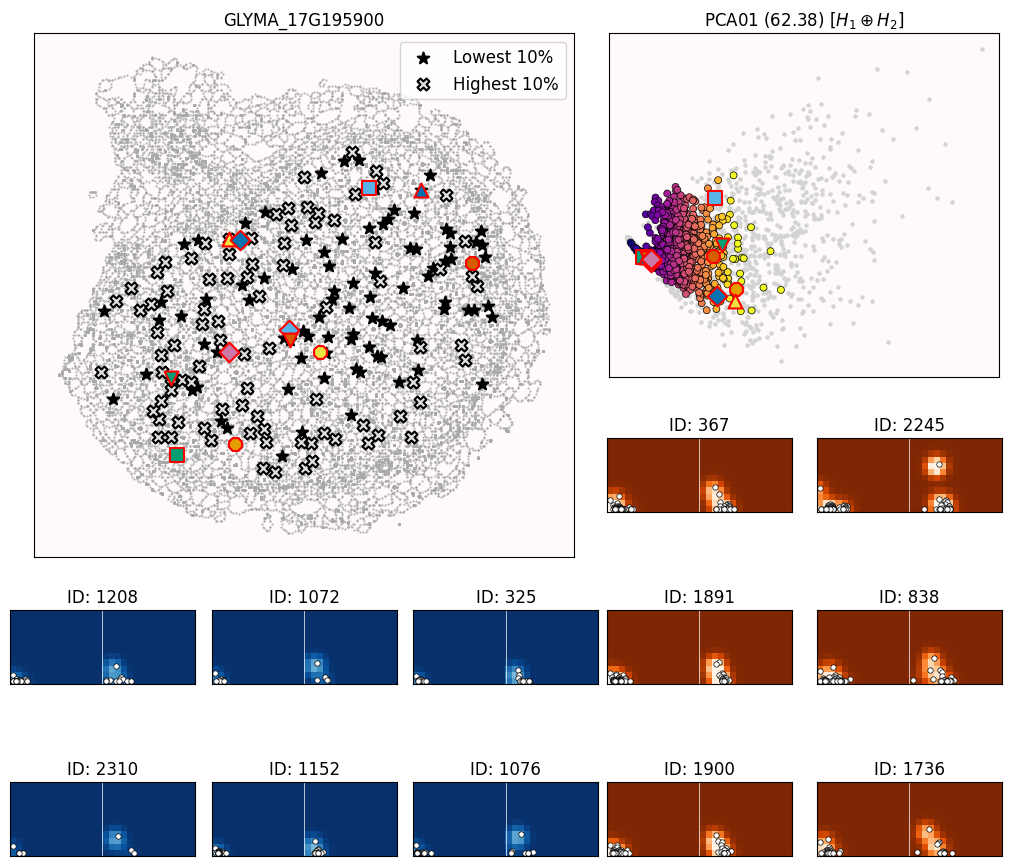

In [49]:
fig = plt.figure(figsize=(10,9), layout="constrained")
gs = GridSpec(5, 5, figure=fig)
fig.add_subplot(gs[:3, :3])
fig.add_subplot(gs[:2, 3:])
for i in range(3,gs.nrows):
    for j in range(3):
        fig.add_subplot(gs[i,j])
for i in range(2,gs.nrows):
    for j in range(3, gs.ncols):
        fig.add_subplot(gs[i,j])
        
i = 0
fig.axes[i].set_title(transcriptomes[Genes[gidx]], fontsize=fs)
fig.axes[i].scatter(wc[1], wc[0], c='darkgray', marker='.', s=1, zorder=1)
for j, (qmask, ll) in enumerate(zip([lqmask, hqmask], ['Low','High'])):
    fig.axes[i].scatter(*(cellloc[qmask, :2].T), c=color[-1-j], marker=marker[-j-1], label=ll+'est {}%'.format(int(100*qq)),
                        edgecolor='black', linewidth=1.5, zorder=j+2, s=1.5*s)
fig.axes[i].legend(fontsize=fs)
for j, [x,y,idx] in enumerate(cellloc[np.hstack((lq,hq))]):
    fig.axes[i].scatter(x, y, marker=marker[j%5], c=color[j%7], edgecolor='r', linewidth=1.5, zorder=3, s=2*s, label=idx)
h, l = fig.axes[i].get_legend_handles_labels()

i = 1
fig.axes[i].set_title(embedding.columns[2+pcnum]+Pname, fontsize=fs)
fig.axes[i].scatter(*(pca[~pmask].T), c='lightgray', marker='o', s=5, alpha=1, zorder=1)
fig.axes[i].scatter(*(pca[pmask].T), c=arr, marker='o', s=0.5*s, zorder=2, cmap='plasma', vmax=vmax, vmin=vmin, edgecolor='k', linewidth=0.5)
for j in range(len(reps)):
    x,y = pca[reps[j]]
    fig.axes[i].scatter(pca[reps[j],0], pca[reps[j],1], marker=marker[j%5], c=color[j%7], edgecolor='r', linewidth=1.5, zorder=3, s=2*s)

j = 2
for i in range(j , len(fig.axes)):
    fig.axes[i].imshow(img[i-j].T, cmap=cmap[4*((i-j)//N)], vmin=0, vmax=imvmax, origin='lower')
    for k in range(1, len(hdims)):
        fig.axes[i].axvline(k*full_img.shape[2] - .5, c='white', lw=0.5)
    fig.axes[i].scatter(lt_coll[i-j][:,0], lt_coll[i-j][:,1], c='w', marker='o', s=15, edgecolor='k', linewidth=0.5)
    fig.axes[i].set_title('ID: {}'.format(orig_idx[i-j]), fontsize=fs)

for i in range(2):
    fig.axes[i].set_aspect('equal')
    fig.axes[i].set_facecolor('snow')
for i in range(len(fig.axes)):
    fig.axes[i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

filename = dsrc + bname + method.lower() + '_' + pname + '_PI_{:02d}_{}'.format(pcnum+1, transcriptomes[Genes[gidx]])
#plt.savefig(filename, dpi=dpi, bbox_inches='tight', pil_kwargs={'optimize':True})

In [18]:
KDE = [None for _ in range(len(reps))]
hcells = [None for _ in range(len(reps))]
hcoords = [None for _ in range(len(reps))]
hextent = [None for _ in range(len(reps))]
hzhist = [None for _ in range(len(reps))]

for i in range(len(KDE)):
    cidx = embedding.loc[reps[i], 'ndimage_ID']
    cell, cextent = utils.get_cell_img(cidx, metacell, wall, label, pxbar=False)
    axes, grid, gmask, cgrid, cgridmask = utils.cell_grid_preparation(cell, cextent, zmax, stepsize)
    cmask = label[ translocs[ embedding.loc[reps[i], 'gene_ID']]['Y'], translocs[embedding.loc[reps[i], 'gene_ID']]['X'] ] == cidx
    coords = translocs[embedding.loc[reps[i], 'gene_ID']].iloc[cmask].values.T
    zhist, _ = np.histogram(coords[2], bins=zbins, density=True)
    
    w = weight[tcumsum[embedding.loc[reps[i], 'gene_ID']] : tcumsum[embedding.loc[reps[i], 'gene_ID']+1]][cmask]
    kde = FFTKDE(kernel='gaussian', bw=bw, norm=2).fit(coords.T, w).evaluate(grid)
    kde = kde[gmask]/( np.sum(kde[gmask]) * (stepsize**len(coords)) )
    kde[ cgridmask ] = 0
    kde = kde/( np.sum(kde) * (stepsize**len(coords)) )
    
    KDE[i] = kde.reshape( list(map(len, axes))[::-1], order='F')
    hcells[i] = cell
    hextent[i] = cextent
    hcoords[i] = coords
    hzhist[i] = zhist

for cell in hcells:
    cell[pxbar] = 0

hkdes = [ KDE[i].copy() * ratios[invGenes[embedding.loc[reps[i], 'gene_ID']]][ invCells[embedding.loc[reps[i], 'ndimage_ID']] ] for i in range(len(KDE))]
if normtype == 'gene':
    for i in range(len(hkdes)):
        hkdes[i] *= rescale[invGenes[embedding.loc[reps[i], 'gene_ID']]][0][0]
hzlevel = np.array(list(map(np.argmax, hzhist)))

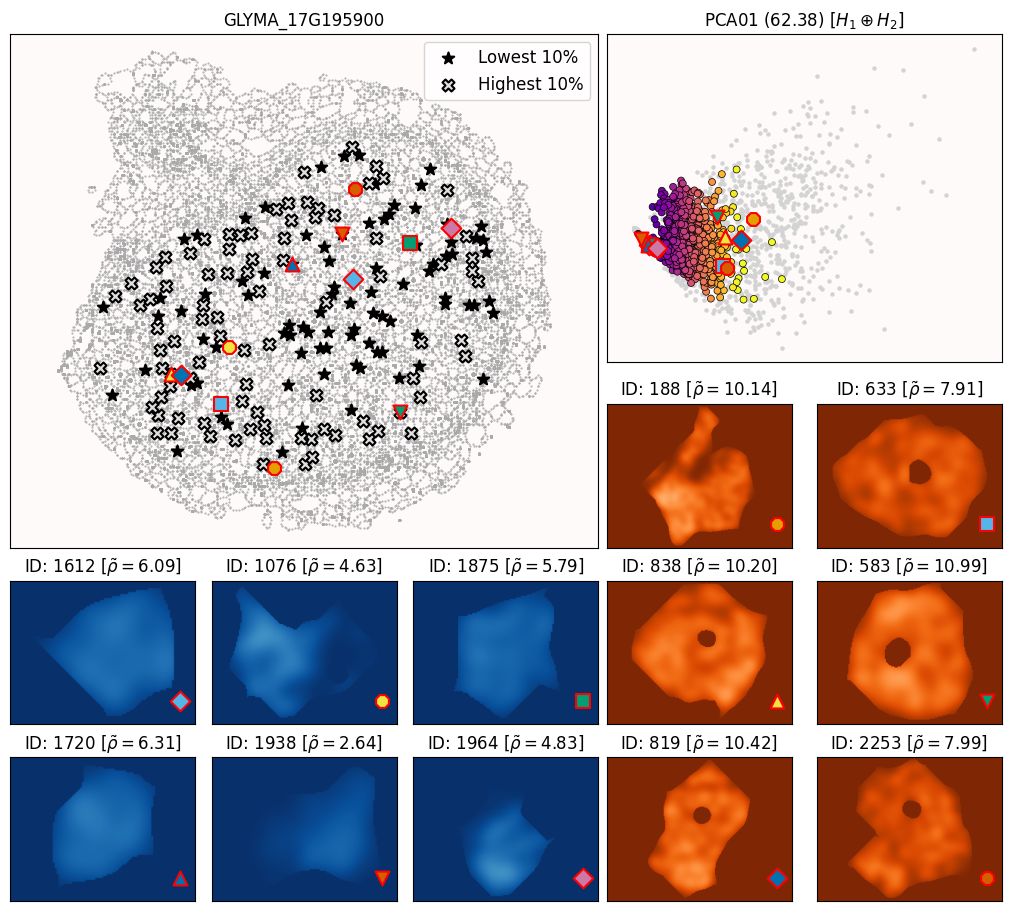

In [20]:
fig = plt.figure(figsize=(10,9), layout="constrained")
gs = GridSpec(5, 5, figure=fig)
fig.add_subplot(gs[:3, :3])
fig.add_subplot(gs[:2, 3:])
for i in range(3,gs.nrows):
    for j in range(3):
        fig.add_subplot(gs[i,j])
for i in range(2,gs.nrows):
    for j in range(3, gs.ncols):
        fig.add_subplot(gs[i,j])
        
i = 0
fig.axes[i].set_title(transcriptomes[Genes[gidx]], fontsize=fs)
fig.axes[i].scatter(wc[1], wc[0], c='darkgray', marker='.', s=1, zorder=1)
for j, (qmask, ll) in enumerate(zip([lqmask, hqmask], ['Low','High'])):
    fig.axes[i].scatter(*(cellloc[qmask, :2].T), c=color[-1-j], marker=marker[-j-1], label=ll+'est {}%'.format(int(100*qq)),
                        edgecolor='black', linewidth=1.5, zorder=j+2, s=1.5*s)
fig.axes[i].legend(fontsize=fs)
for j, [x,y,idx] in enumerate(cellloc[np.hstack((lq,hq))]):
    fig.axes[i].scatter(x, y, marker=marker[j%5], c=color[j%7], edgecolor='r', linewidth=1.5, zorder=3, s=2*s, label=idx)
h, l = fig.axes[i].get_legend_handles_labels()

i = 1
fig.axes[i].set_title(embedding.columns[2+pcnum]+Pname, fontsize=fs)
fig.axes[i].scatter(*(pca[~pmask].T), c='lightgray', marker='o', s=5, alpha=1, zorder=1)
fig.axes[i].scatter(*(pca[pmask].T), c=arr, marker='o', s=0.5*s, zorder=2, cmap='plasma', vmax=vmax, vmin=vmin, edgecolor='k', linewidth=0.5)
for j in range(len(reps)):
    x,y = pca[reps[j]]
    fig.axes[i].scatter(pca[reps[j],0], pca[reps[j],1], marker=marker[j%5], c=color[j%7], edgecolor='r', linewidth=1.5, zorder=3, s=2*s)
    
j = 2
for i in range(j , len(fig.axes)):
    fig.axes[i].imshow(hkdes[i-j][hzlevel[i-j],:,:], origin='lower', cmap=cmap[4*((i-j)//N)], vmin=0, vmax=kmax)
    fig.axes[i].set_facecolor( mpl.colormaps[ cmap[4*((i-j)//N)] ](0) )
    fig.axes[i].set_title('ID: {} '.format(orig_idx[i-j]) + '[$\\tilde{\\rho}=$' + '{:.2f}]'.format(density[i-j]), fontsize=fs)
    fig.axes[i].legend( [ h[i] ], [''], fontsize=fs, loc='lower right', framealpha=0, handlelength=0, handletextpad=0)
for i in range(2):
    fig.axes[i].set_facecolor('snow')
for i in range(len(fig.axes)):
    fig.axes[i].set_aspect('equal', 'datalim')
    fig.axes[i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

filename = dsrc + bname + method.lower() + '_' + pname + '_kde_{:02d}_{}'.format(pcnum+1, transcriptomes[Genes[gidx]])
#plt.savefig(filename, dpi=dpi, bbox_inches='tight', pil_kwargs={'optimize':True})

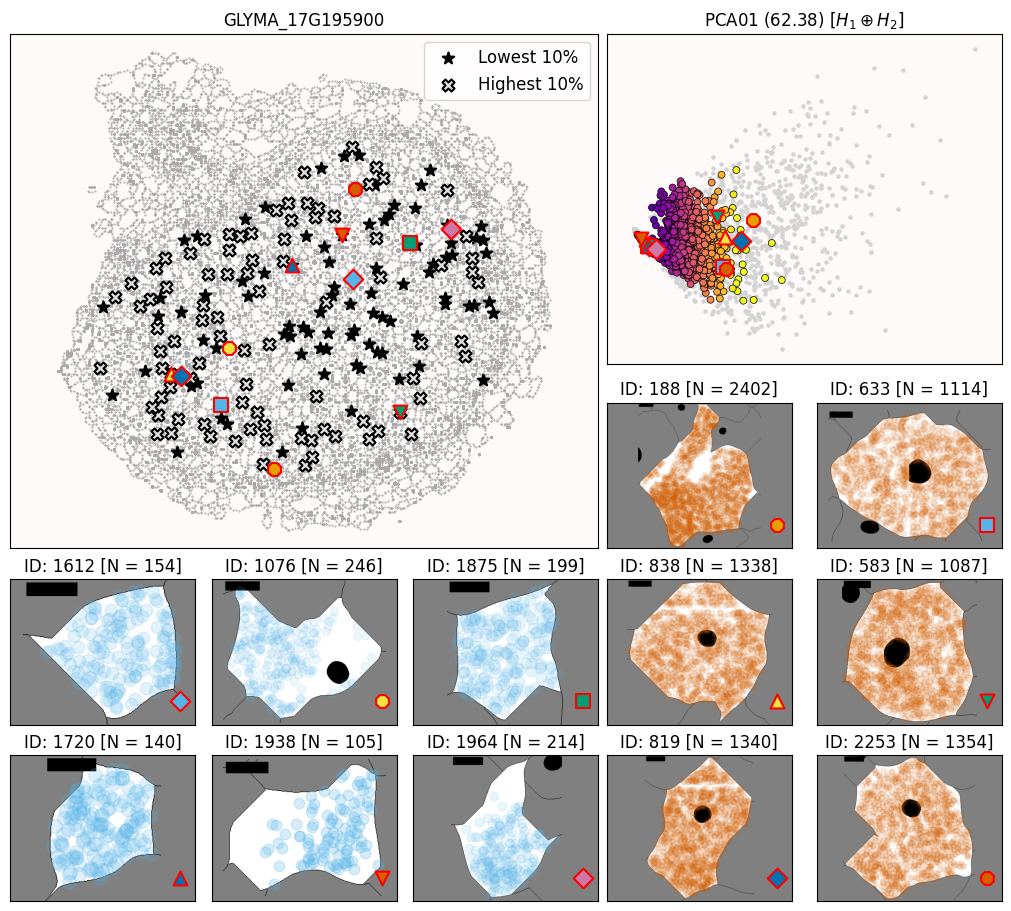

In [25]:
fig = plt.figure(figsize=(10,9), layout="constrained")
gs = GridSpec(5, 5, figure=fig)
fig.add_subplot(gs[:3, :3])
fig.add_subplot(gs[:2, 3:])
for i in range(3,gs.nrows):
    for j in range(3):
        fig.add_subplot(gs[i,j])
for i in range(2,gs.nrows):
    for j in range(3, gs.ncols):
        fig.add_subplot(gs[i,j])
        
i = 0
fig.axes[i].set_title(transcriptomes[Genes[gidx]], fontsize=fs)
fig.axes[i].scatter(wc[1], wc[0], c='darkgray', marker='.', s=1, zorder=1)
for j, (qmask, ll) in enumerate(zip([lqmask, hqmask], ['Low','High'])):
    fig.axes[i].scatter(*(cellloc[qmask, :2].T), c=color[-1-j], marker=marker[-j-1], label=ll+'est {}%'.format(int(100*qq)),
                        edgecolor='black', linewidth=1.5, zorder=j+2, s=1.5*s)
fig.axes[i].legend(fontsize=fs)
for j, [x,y,idx] in enumerate(cellloc[np.hstack((lq,hq))]):
    fig.axes[i].scatter(x, y, marker=marker[j%5], c=color[j%7], edgecolor='r', linewidth=1.5, zorder=3, s=2*s, label=idx)
h, l = fig.axes[i].get_legend_handles_labels()

i = 1
fig.axes[i].set_title(embedding.columns[2+pcnum]+Pname, fontsize=fs)
fig.axes[i].scatter(*(pca[~pmask].T), c='lightgray', marker='o', s=5, alpha=1, zorder=1)
fig.axes[i].scatter(*(pca[pmask].T), c=arr, marker='o', s=0.5*s, zorder=2, cmap='plasma', vmax=vmax, vmin=vmin, edgecolor='k', linewidth=0.5)
for j in range(len(reps)):
    x,y = pca[reps[j]]
    fig.axes[i].scatter(pca[reps[j],0], pca[reps[j],1], marker=marker[j%5], c=color[j%7], edgecolor='r', linewidth=1.5, zorder=3, s=2*s)
    
j = 2
for i in range(j , len(fig.axes)):
    fig.axes[i].imshow(hcells[i-j], cmap='binary_r', origin='lower', extent=hextent[i-j], vmin=0, vmax=2);
    fig.axes[i].scatter(hcoords[i-j][0], hcoords[i-j][1], color=color[4*((i-j)//N)], marker='o', s=int(4e6/hcells[i-j].size),
                       alpha=max([0.1, min([1, 25/len(hcoords[i-j][0])])]))
    fig.axes[i].set_facecolor('#808080')
    fig.axes[i].set_title('ID: {} [N = {}]'.format(orig_idx[i-j], len(hcoords[i-j][0])), fontsize=fs)
    fig.axes[i].legend( [ h[i] ], [''], fontsize=fs, loc='lower right', framealpha=0, handlelength=0, handletextpad=0)
for i in range(2):
    fig.axes[i].set_facecolor('snow')
for i in range(len(fig.axes)):
    fig.axes[i].set_aspect('equal', 'datalim')
    fig.axes[i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

filename = dsrc + bname + method.lower() + '_' + pname + '_cell_{:02d}_{}'.format(pcnum+1, transcriptomes[Genes[gidx]])
#plt.savefig(filename, dpi=dpi, bbox_inches='tight', pil_kwargs={'optimize':True})

# PCA differences

In [25]:
print(dimg.shape, full_img.shape)

(2, 926, 15, 12) (3, 4809, 15, 12)


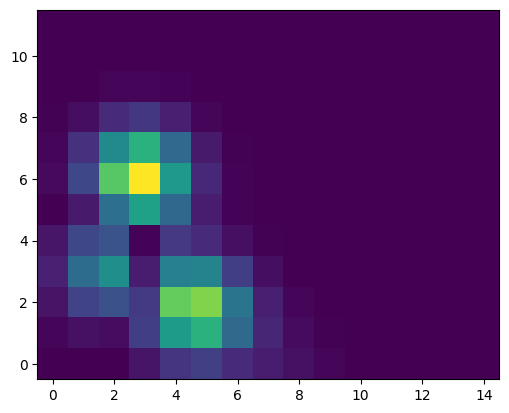

In [42]:
plt.imshow(dimg[1,3].T, origin='lower', vmin=0);

In [66]:

diffs = np.array([ np.max(np.linalg.norm( dimg, ord=ord, axis=2), axis=0) for ord in ord_comparison ])

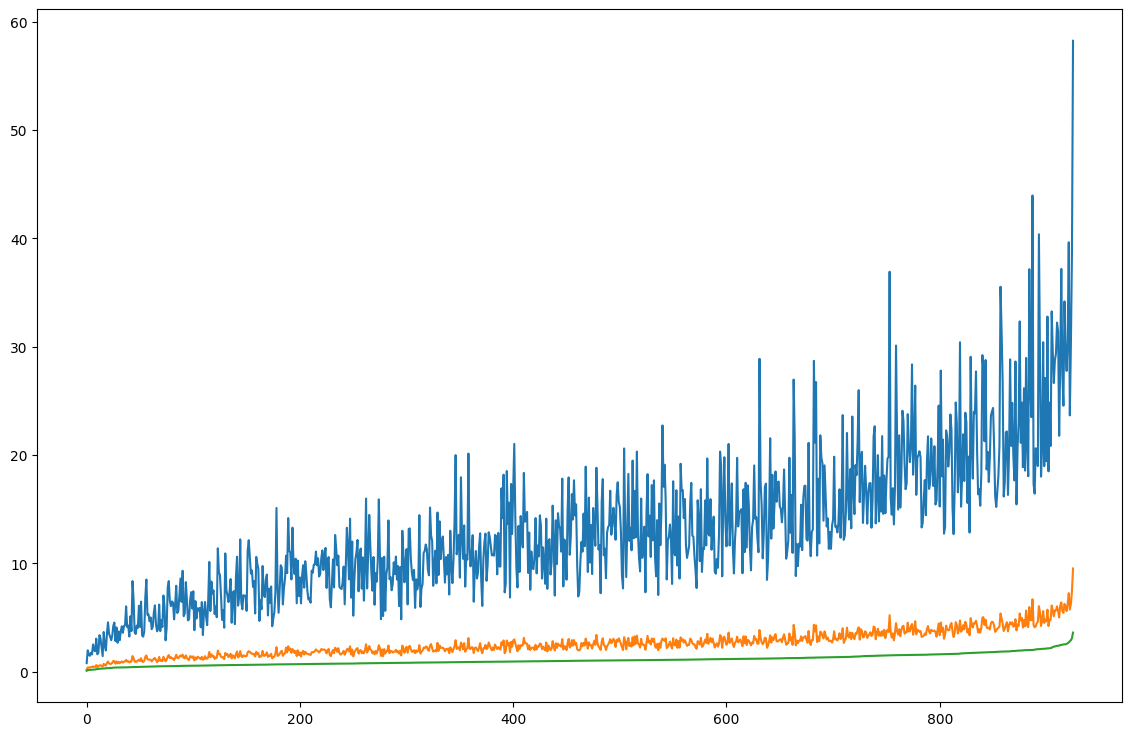

In [71]:
argsort = np.argsort(diffs[2])
fig, ax = plt.subplots(1,1, figsize=(14,9), sharex=False, sharey=False)
for i in range(len(diffs)):
    ax.plot(range(len(diffs[i])), diffs[i][argsort])

In [89]:
gi, gj = 0,5

ord_comparison = [1,2,np.inf]
pca_comparison = [ [0], [1], [0,1] ]
merge = embedding[embedding['gene_ID'] == Genes[gi]].merge(embedding[embedding['gene_ID'] == Genes[gj]], how='inner',
                                                           on = 'ndimage_ID', suffixes=['_{}'.format(i) for i in [gi,gj]])
imi = [embedding[(embedding['ndimage_ID'] == i) & (embedding['gene_ID'] == Genes[gi])].index[0] for i in merge['ndimage_ID'] ]
imj = [embedding[(embedding['ndimage_ID'] == i) & (embedding['gene_ID'] == Genes[gj])].index[0] for i in merge['ndimage_ID'] ]
dimg = np.abs(full_img[hdims][:, imi] - full_img[hdims][:, imj])
dimg = dimg.reshape(dimg.shape[0],dimg.shape[1],dimg.shape[2]*dimg.shape[3])

diff_option = [[ [embedding.columns[2+i]+'_{}'.format(x) for i in perm ] for x in [gi,gj] ] for perm in pca_comparison]
title = ['$\\Delta$ ' + '$\\oplus$'.join(['PC{}'.format(x+1) for x in perm ])  for perm in pca_comparison]
title += ['$L_{{{}}}(\\Delta$ PI)'.format(ord).replace('inf','\\infty') for ord in ord_comparison] 

ftitle = ['+'.join(['{}'.format(x+1) for x in perm ])  for perm in pca_comparison]
ftitle += ['L{}'.format(ord) for ord in ord_comparison] 

diffs_pc = np.array([ np.linalg.norm(merge.loc[:, diff_option[i][0]].values - merge.loc[:, diff_option[i][1]].values, ord=2, axis=1) for i in range(len(diff_option))])
diffs_pi = np.array([ np.max(np.linalg.norm( dimg, ord=ord, axis=2), axis=0) for ord in ord_comparison ])

diffs = np.vstack((diffs_pc, diffs_pi))


In [17]:
cellloc = metacell.loc[ merge['ndimage_ID'], ['ndimage_comX','ndimage_comY','orig_cellID'] ].values
dists = spatial.distance.squareform(spatial.distance.pdist(cellloc[:,:2], metric='euclidean'), checks=False)

ord = 1
ecc = np.linalg.norm(dists, ord=ord, axis=1)
if ord < np.inf:
    ecc *= np.power(1/len(ecc), 1/ord)
ecc -= ecc.min()

../infected_focus_summer24/D2/G6_sublevel_both_step3_bw20/scale16_-_PI_1_1_1_pca_H1+2_GLYMA_17G195900_vs_GLYMA_05G092200


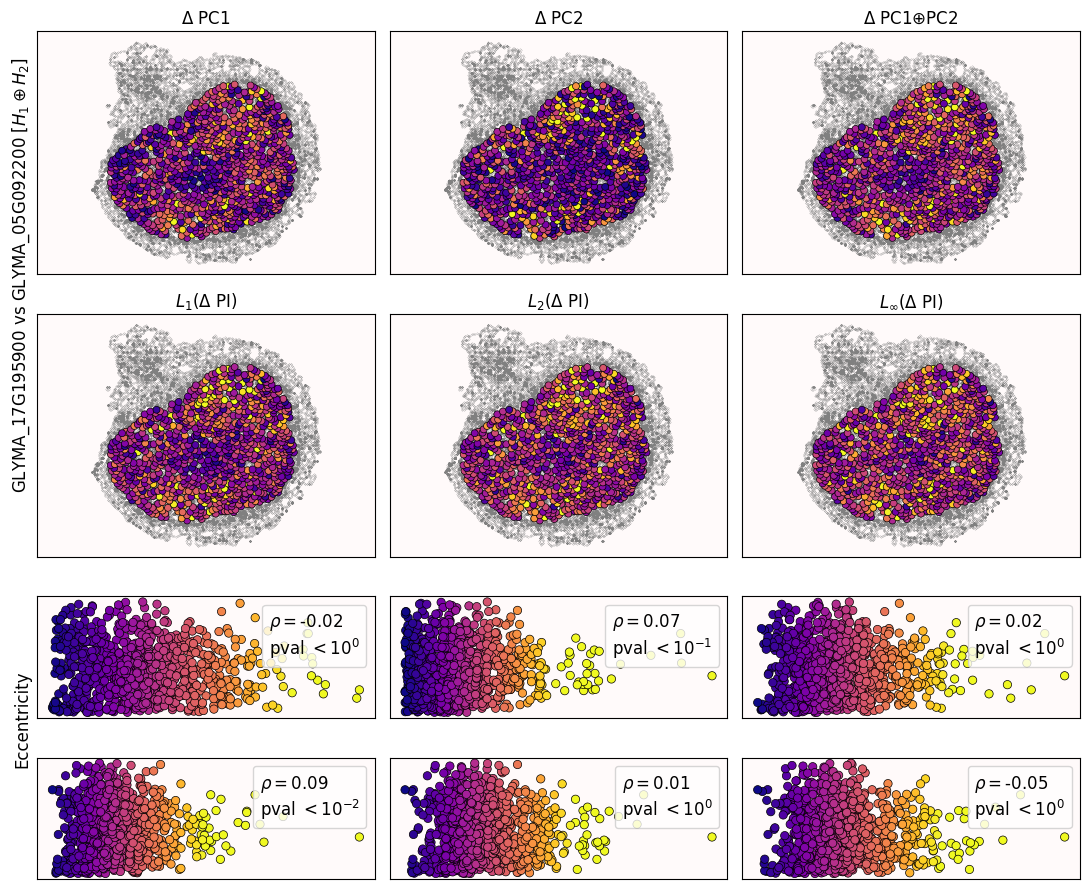

In [105]:
fig, ax = plt.subplots(4, len(diff_option), figsize=(11,9), sharex=False, sharey=False, height_ratios=[2,2,1,1])
ax[0,0].set_ylabel('{} vs {}'.format(*transcriptomes[Genes[[gi,gj]]]) + Pname, fontsize=fs, y=0)
ax[2,0].set_ylabel('Eccentricity', fontsize=fs, y=0)

for i in range(len(diffs)):
    j = ((i//ax.shape[1]), i%ax.shape[1])
    k = ((i//ax.shape[1])+2, i%ax.shape[1])
    ax[j].set_title(title[i], fontsize=fs)
    diff = diffs[i]
    vmin = utils.minimum_qq_size( diff, alpha=0.25, iqr_factor=1.5)
    vmax = utils.maximum_qq_size( diff, alpha=0.25, iqr_factor=1.5)
    
    ax[j].scatter(wc[1], wc[0], c='#808080', marker='.', s=0.1, zorder=1)
    ax[j].scatter(cellloc[:,0], cellloc[:,1], c=diff, marker='o', cmap='plasma',
                     edgecolor='black', linewidth=0.5, zorder=2, s=25, vmin=vmin, vmax=vmax)
    ax[j].set_aspect('equal', 'datalim')

    corr = stats.spearmanr(ecc, diff)
    expo = int(np.ceil(np.log10(corr.pvalue)))
    ll = '$\\rho = ${:.2f}\npval $< 10^{{{}}}$'.format(corr.statistic, expo)
    ax[k].scatter(diff, ecc, c=diff, cmap=Cmap, marker='o', edgecolor='black', linewidth=0.5, vmin=vmin, vmax=vmax, label=ll)
    ax[k].legend(fontsize=fs, handlelength=0, handletextpad=0, loc='upper right', markerscale=0)

for a in ax.ravel():
    a.set_facecolor('snow')
    a.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

fig.tight_layout();
filename = dsrc + bname + method.lower() + '_' + pname + '_{}_vs_{}'.format(*transcriptomes[Genes[[gi,gj]]])
print(filename)
plt.savefig(filename, dpi=dpi, bbox_inches='tight', pil_kwargs={'optimize':True})

# Visualize those differences

In [27]:
dixd = 2
diff = diffs[dixd]
vmin = utils.minimum_qq_size( diff, alpha=0.25, iqr_factor=1.5)
vmax = utils.maximum_qq_size( diff, alpha=0.25, iqr_factor=1.5)

argsort = np.argsort(diff)
ncol = 6

reps = merge.iloc[np.hstack( (argsort[:ncol], argsort[-ncol:]))]['ndimage_ID'].values
cgi = [embedding[(embedding['ndimage_ID'] == reps[i]) & (embedding['gene_ID'] == Genes[gi])].index[0] for i in range(len(reps))]
cgj = [embedding[(embedding['ndimage_ID'] == reps[i]) & (embedding['gene_ID'] == Genes[gj])].index[0] for i in range(len(reps))]
reps = cgi[:ncol] + cgj[:ncol] + cgi[-ncol:] + cgj[-ncol:]

cyto_area = metacell.loc[ embedding.loc[reps]['ndimage_ID'], 'cyto_area']
tnum = transcell.loc[ transcriptomes[Genes[[gi,gj]]], embedding.loc[cgi[:ncol]]['ndimage_ID'].values.astype(str)].values.ravel()
tnum = np.hstack((tnum,transcell.loc[transcriptomes[Genes[[gi,gj]]],embedding.loc[cgi[-ncol:]]['ndimage_ID'].values.astype(str)].values.ravel()))
density = 1000*tnum/cyto_area.values

In [28]:
lt_coll = [None for _ in range(len(reps))]
for i in range(len(lt_coll)):
    foo = [full_lt_coll[k][reps[i]].copy() for k in hdims]
    for j in range(1, len(hdims)):
        foo[j][:,0] += j*full_img.shape[2]
    lt_coll[i] = np.vstack(foo)
    
img = np.hstack(full_img[hdims])[reps]
vmax = np.quantile(img[img > 1e-5], 0.95)

../infected_focus_summer24/D2/G6_sublevel_both_step3_bw20/scale16_-_PI_1_1_1_pca_H1+2_1+2_PI_GLYMA_17G195900_vs_GLYMA_05G092200


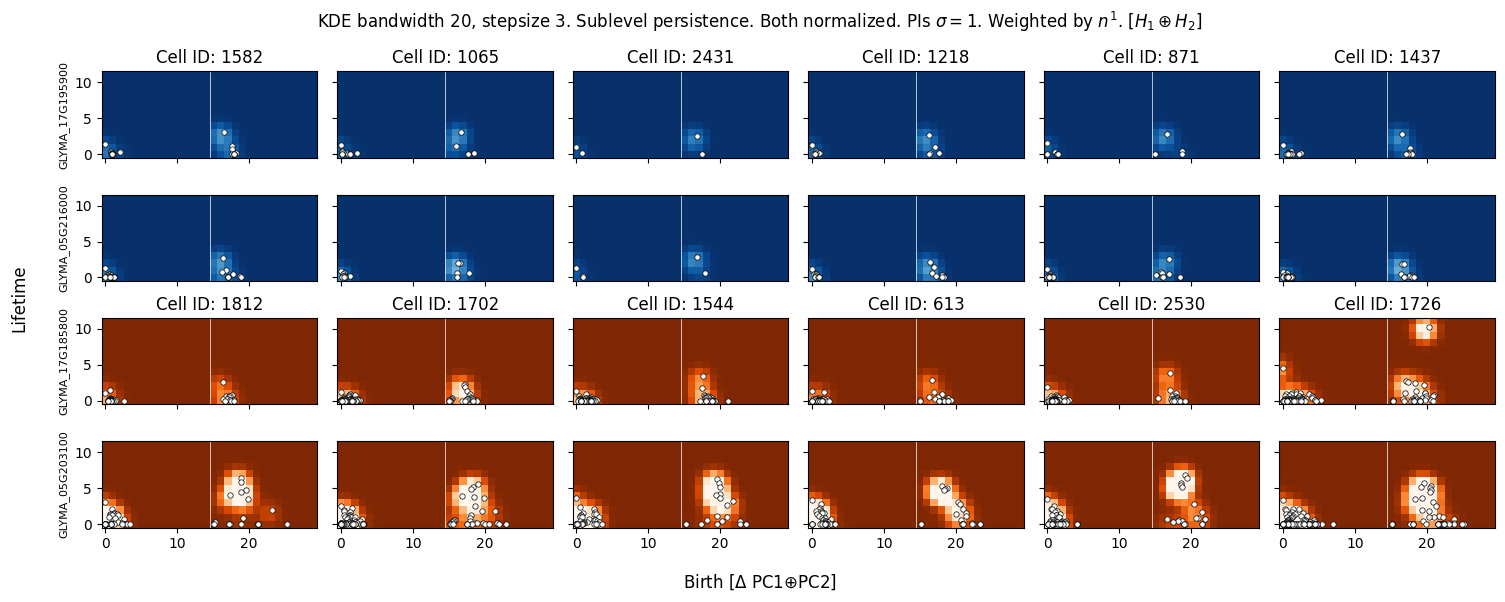

In [29]:
fig, ax = plt.subplots( len(reps)//ncol, ncol, figsize=(15, 6), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel();

for i in range(len(reps)):
    ax[i].imshow(img[i].T, cmap=cmap[4*((i)//(2*ncol))], vmin=0, vmax=vmax, origin='lower')
    for k in range(1, len(hdims)):
        ax[i].axvline(k*full_img.shape[2] - .5, c='white', lw=0.5)
    ax[i].scatter(lt_coll[i][:,0], lt_coll[i][:,1], c='w', marker='o', s=15, edgecolor='k', linewidth=0.5)

for i in range(ncol):
    ax[i].set_title('Cell ID: {}'.format(metacell.loc[embedding.loc[reps[i], 'ndimage_ID'], 'orig_cellID']), fontsize=fs)

for i in range(2*ncol, 3*ncol):
    ax[i].set_title('Cell ID: {}'.format(metacell.loc[embedding.loc[reps[i], 'ndimage_ID'], 'orig_cellID']), fontsize=fs)

for i in [0,2]:
    ax[ncol*i].set_ylabel(transcriptomes[Genes[i]], fontsize=8)
for i in [1,3]:
    ax[ncol*i].set_ylabel(transcriptomes[Genes[i]], fontsize=8)
    
fig.suptitle(Bname + Pname, fontsize=fs)
fig.supylabel('Lifetime', fontsize=fs, x=0.0)
fig.supxlabel('Birth ['+title[dixd]+']', fontsize=fs)
fig.tight_layout();
filename = dsrc + bname + method.lower() + '_' + pname + '_{}_PI_{}_vs_{}'.format(ftitle[dixd], *transcriptomes[Genes[[gi,gj]]])
print(filename)
#plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

In [30]:
KDE = [None for _ in range(len(reps))]
hcells = [None for _ in range(len(reps))]
hcoords = [None for _ in range(len(reps))]
hextent = [None for _ in range(len(reps))]
hzhist = [None for _ in range(len(reps))]

for i in range(len(KDE)):
    cidx = embedding.loc[reps[i], 'ndimage_ID']
    cell, cextent = utils.get_cell_img(cidx, metacell, wall, label, pxbar=False)
    axes, grid, gmask, cgrid, cgridmask = utils.cell_grid_preparation(cell, cextent, zmax, stepsize)
    cmask = label[ translocs[ embedding.loc[reps[i], 'gene_ID']]['Y'], translocs[embedding.loc[reps[i], 'gene_ID']]['X'] ] == cidx
    coords = translocs[embedding.loc[reps[i], 'gene_ID']].iloc[cmask].values.T
    zhist, _ = np.histogram(coords[2], bins=zbins, density=True)
    
    w = weight[tcumsum[embedding.loc[reps[i], 'gene_ID']] : tcumsum[embedding.loc[reps[i], 'gene_ID']+1]][cmask]
    kde = FFTKDE(kernel='gaussian', bw=bw, norm=2).fit(coords.T, w).evaluate(grid)
    kde = kde[gmask]/( np.sum(kde[gmask]) * (stepsize**len(coords)) )
    kde[ cgridmask ] = 0
    kde = kde/( np.sum(kde) * (stepsize**len(coords)) )
    
    KDE[i] = kde.reshape( list(map(len, axes))[::-1], order='F')
    hcells[i] = cell
    hextent[i] = cextent
    hcoords[i] = coords
    hzhist[i] = zhist

tpercell = np.array([len(hcoords[i][0]) for i in range(len(hcells))])
for cell in hcells:
    cell[pxbar] = 0

hkdes= [ KDE[i].copy() * ratios[invGenes[embedding.loc[reps[i], 'gene_ID']]][ invCells[embedding.loc[reps[i], 'ndimage_ID']] ] for i in range(len(KDE))]
if normtype == 'gene':
    for i in range(len(hkdes)):
        hkdes[i] *= rescale[invGenes[embedding.loc[reps[i], 'gene_ID']]][0][0]
hzlevel = np.array(list(map(np.argmax, hzhist)))

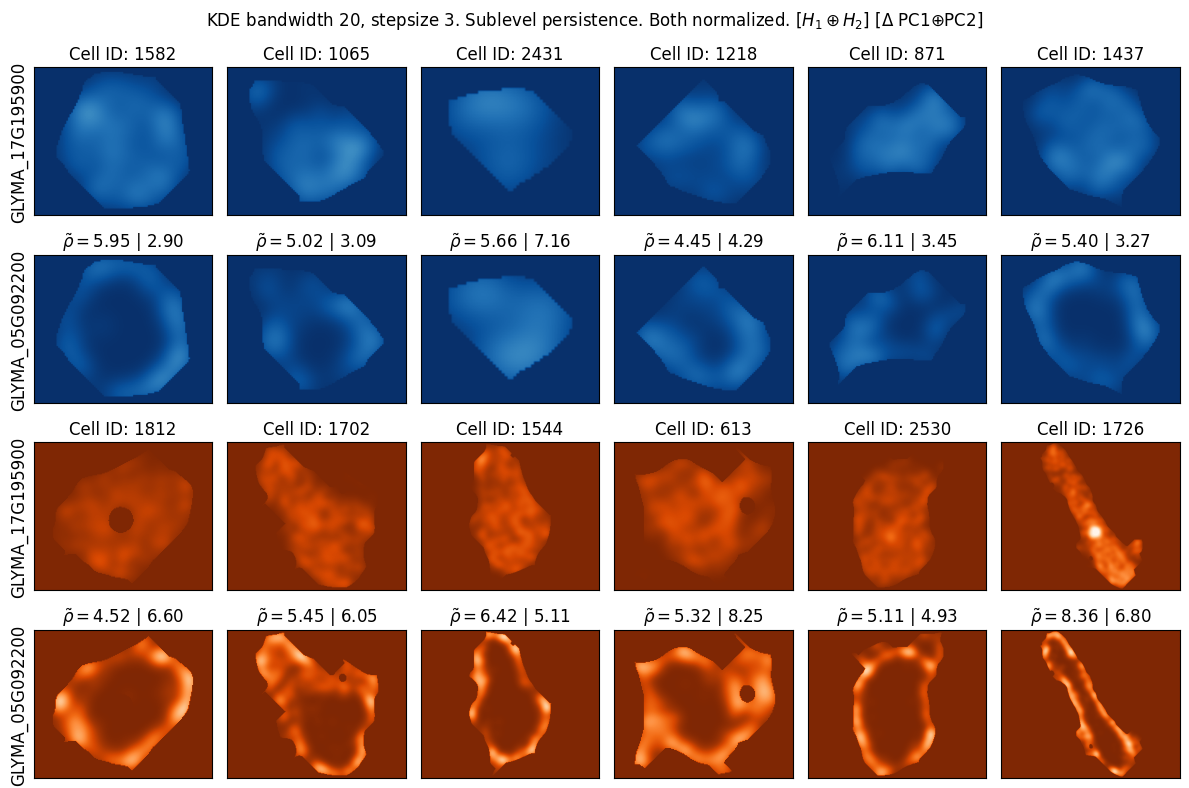

In [38]:
fig, ax = plt.subplots( len(reps)//ncol, ncol, figsize=(12, 8), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel();

for i in range(len(KDE)):
    ax[i].imshow(hkdes[i][hzlevel[i],:,:], origin='lower', cmap=cmap[4*(i//(2*ncol))], vmin=0, vmax=kmax, zorder=1)
    ax[i].set_facecolor( mpl.colormaps[ cmap[4*((i)//(2*ncol))] ](0) )
    ax[i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    
for kstart, kend in [(0, ncol), (2*ncol, 3*ncol)]:
    for i in range(kstart, kend):
        ax[i].set_title('Cell ID: {}'.format(metacell.loc[embedding.loc[reps[i], 'ndimage_ID'], 'orig_cellID']), fontsize=fs)
        ax[i+ncol].set_title('$\\tilde{\\rho}=$'+'{:.2f} | {:.2f}'.format(*density[[i,ncol+i]]), fontsize=fs)
        
for i in [0,2]:
    ax[ncol*i].set_ylabel(transcriptomes[Genes[gi]], fontsize=12)
for i in [1,3]:
    ax[ncol*i].set_ylabel(transcriptomes[Genes[gj]], fontsize=12)

for a in ax.ravel():
    a.set_aspect('equal','datalim')

fig.suptitle(Bname[:68] + Pname + ' ['+title[dixd]+']', fontsize=fs)
fig.tight_layout();
filename = dsrc + bname + method.lower() + '_' + pname + '_{}_kde_{}_vs_{}'.format(ftitle[dixd], *transcriptomes[Genes[[gi,gj]]])
#plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

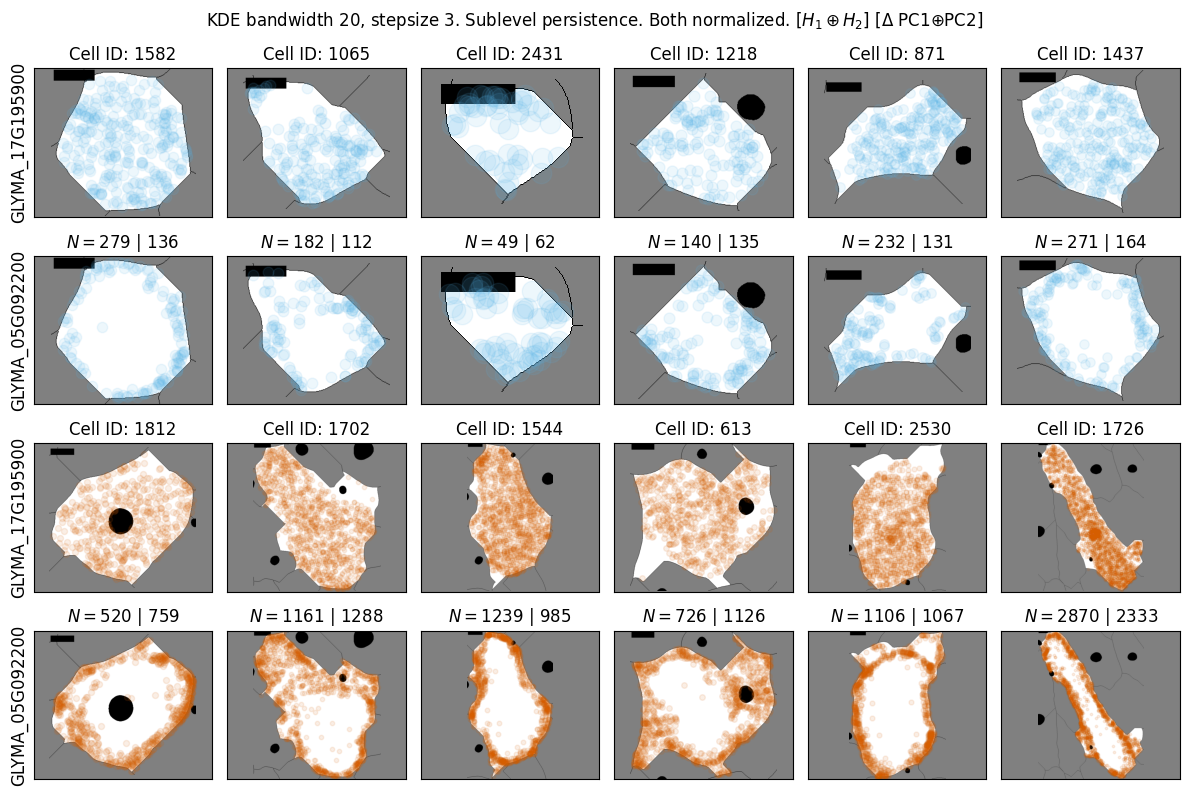

In [37]:
fig, ax = plt.subplots( len(reps)//ncol, ncol, figsize=(12, 8), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel();

for i in range(len(hcells)):
    fig.axes[i].imshow(hcells[i], cmap='binary_r', origin='lower', extent=hextent[i], vmin=0, vmax=2);
    fig.axes[i].scatter(*hcoords[i][:2], color=color[4*(i//(2*ncol))], marker='o', alpha=0.1, s=int(4e6/hcells[i].size))
    fig.axes[i].set_facecolor('#808080')
    ax[i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    
for kstart, kend in [(0, ncol), (2*ncol, 3*ncol)]:
    for i in range(kstart, kend):
        ax[i].set_title('Cell ID: {}'.format(metacell.loc[embedding.loc[reps[i], 'ndimage_ID'], 'orig_cellID']), fontsize=fs)
        ax[i+ncol].set_title('$N=$'+'{} | {}'.format(len(hcoords[i][0]), len(hcoords[ncol+i][0])), fontsize=fs)
        
for i in [0,2]:
    ax[ncol*i].set_ylabel(transcriptomes[Genes[gi]], fontsize=12)
for i in [1,3]:
    ax[ncol*i].set_ylabel(transcriptomes[Genes[gj]], fontsize=12)

for a in ax.ravel():
    a.set_aspect('equal','datalim')

fig.suptitle(Bname[:68] + Pname + ' ['+title[dixd]+']', fontsize=fs)
fig.tight_layout();
filename = dsrc + bname + method.lower() + '_' + pname + '_{}_cell_{}_vs_{}'.format(ftitle[dixd], *transcriptomes[Genes[[gi,gj]]])
#plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

# Comparing PIs directly ($L_\infty$ norm)

# Explore